In [ ]:
!pip install cvxpy
!pip install mosek

     |████████████████████████████████| 10.1 MB 4.5 MB/s 


In [1]:
import pandas as pd
import cvxpy as cp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz

# Model

## Assumptions

1. flat surface,
2. pre-timed signals,
3. vehicle platoon with previous knowledge of the signal timings,
4. vehicle enter the corridor with 0 velocity,
5. constant air density and neglect wind pressure,
6. 

In [2]:
# constant to define

## Shared across platforms

m = 1650                # average vehicle mass [kg]
rho = 1.22              # air density [kg/m^3]
Cd = 0.3                # drag coefficient
Aref = 2.1              # average vehicle frontal area [m^2]
g = 9.81                # gravity constant [m/s^2]
Crr = 0.01              # rolling resistance coefficient
r = 0.31                # wheel radius [m]

## ICE only
f_ice = 0.375           # idle fuel consumption [ml/s]

## EV only
# f_ev =                # idle energy consumption[ml/s]
capacity_kWh = 70       # [kWh]
Voc = 350               # [V]
Pmax_kW = 200           # [KW]
Tmax_Nm = 400           # [Nm]
Tmax_rpm = 3000         # [rpm] max motor speed at max torque
gear_ratio = 8          # motor to driven axle gear ratio
max_speed = 10000       # [rpm] maximum motor speed
dt_eff = 0.7            # drivetrain efficiency
Kemf = Voc/10000        # motor constant
Rcirc = 0.05            # [Ohms]
regen_eff = 0.5         # regenerative braking efficiency
Ki = 0.7                # current to torque constant

# Optimization Formulation

## 1. Optimization of one vehicle trajectory through pre-timed signalized intersections

x(t) = [s(t), v(t)], states: position and velocity \\
u(t) = [a(t)], control param: vehicle acceleration 

In [3]:
# Assumptions:

# Solve with CVXPY

# Define optimization vars
N = 200 # minimum time is N~=pos_final/10*0.9
dt = 1
M = 1e5
x1 = cp.Variable(N+1) # Position
x2 = cp.Variable(N+1) # Velocity
T = cp.Variable(N) # Powertrain torque
Tbrake = cp.Variable(N) # Powertrain braking torque
Fdrag = cp.Variable(N) # Vehicle drag
E = cp.Variable(N+1) # Battery energy
Pmot = cp.Variable(N) # Battery power
Vmot = cp.Variable(N) # Motor voltage
Vcirc = cp.Variable(N) # Circuit voltage
Vcircbrake = cp.Variable(N) # Circuit voltage under braking
Vbrake = cp.Variable(N) # Battery voltage under regeneration
I = cp.Variable(N) # Motor current
Ibrake = cp.Variable(N) # Battery voltage under regeneration
SOC = cp.Variable(N+1) # Battery SOC
pedal = cp.Variable(N, integer=True) # 0=brake, 1=accelerator

# Define objective function
objective = cp.Minimize( E[0]-E[N] ); title = 'Minimum Energy' # Minimum energy
# objective = cp.Minimize(-x1@np.ones(N+1)); title = 'Minimum Time' # Minimum time - Lower N until solver fails for guaranteed minimum time

# Define constraints
pos_final = 2000 # m
vel_lower = 0 # m/s
vel_upper = 17.5 # m/s
acc_abs = 1.5 # m/s^2
jerk_abs = 1 # m/s^3
lin_drag = 10 # linearize drag about this speed
constraints = [ ]
# pos_init = 0 m
constraints += [ x1[0] == 0 ]
# pos_final = 1000 m
constraints += [ x1[N] == pos_final ]
# vel_init = 0 m/s
constraints += [ x2[0] == 0 ]
# vel_final = 0 m/s
constraints += [ x2[N] == 0 ]
# # acc_init = 0 m/s^2
constraints += [ x2[1] == x2[0] ]
# # acc_final = 0 m/s^2
constraints += [ x2[N] == x2[N-1] ]
# Traffic light constraints
# Define a traffic light as [initial time, final time, position]

tls = []
redlight = 30 # redlight duration [sec]
greenlight = 50 # greenlight duration [sec]
block = 240 # length of one block [m]
for intersection in np.arange(0, pos_final, block):
    for start in np.arange(10, N*dt, redlight + greenlight):
        tls.append([start, start + redlight, intersection])

tls_bools = {}
tls_on = True # Control whether or not traffic lights are used
# The for loop below will automatically create constraints for all traffic lights
for i in range(len(tls)):
    # Ensure that traffic light fits into optimization horizon
    if int(tls[i][0]/dt) <= N and tls_on:            
        dict_index = "tl{0}".format(i)
        tls_bools[dict_index] = cp.Variable(1, boolean=True)
        # Clip end of traffic light if it goes past optimization horizon
        t_initial = int(tls[i][0]/dt)
        if int(tls[i][1]/dt) > N:
            t_final = N
        else:
            t_final = int(tls[i][1]/dt)
        position = tls[i][2]
        constraints += [ x1[t_final]   - position <=  M*tls_bools[dict_index] ]
        constraints += [ x1[t_initial] - position >= -M*(1-tls_bools[dict_index]) ]

for k in range(0,N):
    # vel_lower >= 0 m/s
    constraints += [ x2[k+1] >= vel_lower ]
    # vel_lower <= 15 m/s (~55 km/hr)
    constraints += [ x2[k+1] <= vel_upper ]
    # acc_lower >= -3 m/s^2
    constraints += [ (x2[k+1] - x2[k])/dt >= -acc_abs ]
    # acc_upper <= 3 m/s^2
    constraints += [ (x2[k+1] - x2[k])/dt <= acc_abs ]
    constraints += [ x1[k+1] == x1[k] + x2[k]*dt ]
    constraints += [ x2[k+1] == x2[k] + ( (T[k]+Tbrake[k])/m/r*gear_ratio*dt_eff - Fdrag[k]/m)*dt ]
    constraints += [ Fdrag[k] == 0.5*rho*Cd*Aref*lin_drag**2 + rho*Cd*Aref*(x2[k]-lin_drag) + m*g*Crr*x2[k]/lin_drag]
    constraints += [ E[k+1] == E[k] - T[k]/Ki*Voc*dt/3600 - regen_eff*Tbrake[k]/Ki*Voc*dt/3600 ]
    # Acceleration
    # Max torque boundary
    constraints += [ T[k] <= Tmax_Nm/(max_speed-Tmax_rpm)*max_speed - (Tmax_Nm/-(max_speed-Tmax_rpm))*x2[k]*60/(2*np.pi*r)*gear_ratio ]
    constraints += [ Vmot[k] == Kemf*x2[k]*60/(2*np.pi*r)*gear_ratio ]
    # Braking
    # Min torque boundary
    constraints += [ Tbrake[k] >= -(Tmax_Nm/(max_speed-Tmax_rpm)*max_speed - (Tmax_Nm/-(max_speed-Tmax_rpm))*x2[k]*60/(2*np.pi*r)*gear_ratio) ]
    constraints += [ T[k] <= M*pedal[k] ]
    constraints += [ T[k] >= 0 ]
    constraints += [ Vcirc[k] <= M*pedal[k] ]
    constraints += [ Vcirc[k] >= 0 ]
    constraints += [ Tbrake[k] <= 0 ]
    constraints += [ Tbrake[k] >= -M*(1-pedal[k]) ]
    constraints += [ Vcircbrake[k] <= 0 ]
    constraints += [ Vcircbrake[k] >= -M*(1-pedal[k]) ]
    constraints += [ pedal[k] >= 0]
    constraints += [ pedal[k] <= 1]
# To set pedal to 1 and allow T to be negative, uncomment the line below
# and also comment out the two constraints: 1.) T[k]>=0 and 2.) Vcirc[k]>=0
# constraints += [ pedal == 1 ]
# SOC
constraints += [ SOC[0] == 0.8 ]
constraints += [ SOC == E/capacity_kWh/1000]
constraints += [ SOC <= 0.8 ]
constraints += [ SOC >= 0.2 ]
# Power
constraints += [ Pmot <= Vcirc/Rcirc*Voc + Vcircbrake/Rcirc*Voc - (Vcirc)**2/Rcirc - (Vcircbrake)**2/Rcirc ] # Relaxed SOC constraint --> Becomes tight to minimize energy loss
# Voc
constraints += [ Vcirc + Vcircbrake + Vmot <= Voc ]
constraints += [ Vcirc + Vcircbrake + Vmot >= -Voc ]
# Vcirc
constraints += [ Vcirc == T/Ki*Rcirc ]
constraints += [ Vcircbrake == Tbrake/Ki*Rcirc ]
# constraints += [ Vcirc >= 0 ]
# V (motor)
constraints += [ Vmot >= 0 ]
# T (motor)
constraints += [ T <= Tmax_Nm ]
# constraints += [ T >= 0 ]
# Braking
constraints += [ Vbrake <= 0 ]
constraints += [ Vbrake >= -Voc ]
constraints += [ Tbrake <= 0 ]
constraints += [ Tbrake >= -Tmax_Nm ]

for k in range(1, N):
    # Minimize jerk (derivative of acceleration)
    constraints += [ (x2[k+1] - 2*x2[k] + x2[k-1])/dt**2 <= jerk_abs ]
    constraints += [ (x2[k+1] - 2*x2[k] + x2[k-1])/dt**2 >= -jerk_abs ]


In [4]:
prob = cp.Problem(objective, constraints)
prob.solve(verbose=True, solver='MOSEK')
print(prob.status)

                                     CVXPY                                     
                                    v1.1.15                                    
(CVXPY) Oct 27 03:19:46 PM: Your problem has 2631 variables, 4673 constraints, and 0 parameters.
(CVXPY) Oct 27 03:19:46 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 27 03:19:46 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 27 03:19:46 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 27 03:19:47 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Oct 27 03:19:47 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuff

===== Minimum Energy =====
min SOC = 0.7937505041952458
Final SOC = 0.7946191071461068
Recovered SOC = 0.0009809885159387686
max Vel = 17.499999997434408
max Acc = 1.4999999988691624
max Jerk = 0.9999999957161796


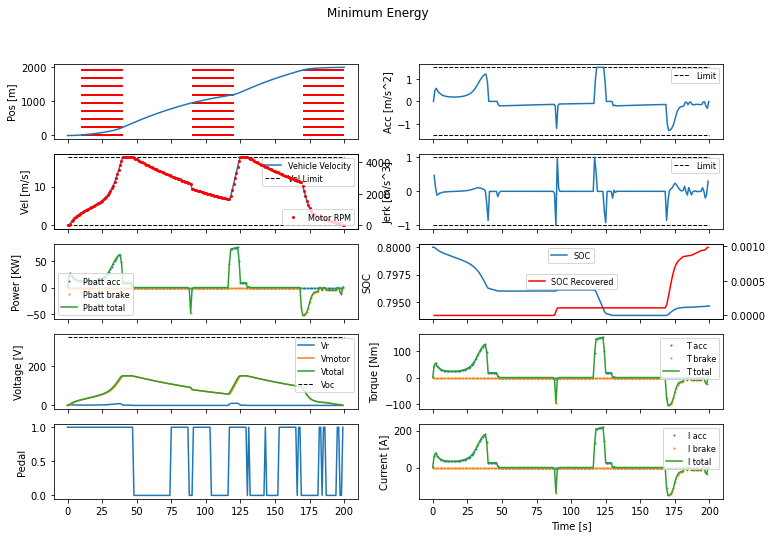

In [5]:
print(f"======{'='*len(title)}======")
print(f"===== {title} =====")
print(f"======{'='*len(title)}======")
print(f"min SOC = {np.min(SOC.value)}")
print(f"Final SOC = {(SOC.value[-1])}")
print(f"Recovered SOC = {-regen_eff*np.trapz(Tbrake.value)/Ki*Voc*dt/3600/capacity_kWh/1000}")
print(f"max Vel = {np.max((x2.value))}")
print(f"max Acc = {np.max((x2.value[1:]-x2.value[:-1])/dt)}")
print(f"max Jerk = {np.max((x2.value[2:]-2*x2.value[1:-1]+x2.value[:-2])/dt**2)}")

time = np.arange(0, (N+1)*dt, dt)
# fig, axs = plt.subplots(8, figsize=(8,8), sharex=True)
fig, axs = plt.subplots(5,2, figsize=(12,8), sharex=True)
axs = axs.flatten()
axs[0].plot(time, x1.value)
axs[0].set_ylabel('Pos [m]')
for i in range(len(tls)):
    # Ensure that traffic light fits into optimization horizon
    if int(tls[i][0]/dt) <= N:
        axs[0].hlines(y=tls[i][2], xmin=tls[i][0], xmax=tls[i][1], linewidth=2, color='r')

legend_font = 8
fig.suptitle(title)
axs[2].plot(time, x2.value, label='Vehicle Velocity')
axs[2].hlines(y=vel_lower, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1, label='Vel Limit')
axs[2].hlines(y=vel_upper, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1)
axs[2].legend(loc='upper right', fontsize=legend_font)
axs[2].set_ylabel('Vel [m/s]')
ax2 = axs[2].twinx()
ax2.plot(time, x2.value*60/(2*np.pi*r)*gear_ratio, 'ro', markersize=2, label='Motor RPM')
ax2.legend(loc='lower right', fontsize=legend_font)
axs[1].plot((time[1:]+time[:-1])/2, (x2.value[1:]-x2.value[:-1])/dt)
axs[1].hlines(y=-acc_abs, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1, label='Limit')
axs[1].hlines(y=acc_abs, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1)
axs[1].legend(loc='upper right', fontsize=legend_font)
axs[1].set_ylabel('Acc [m/s^2]')
axs[3].plot((time[2:]+time[:-2])/2, (x2.value[2:]-2*x2.value[1:-1]+x2.value[:-2])/dt**2)
axs[3].hlines(y=-jerk_abs, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1, label='Limit')
axs[3].hlines(y=jerk_abs, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1)
axs[3].legend(loc='upper right', fontsize=legend_font)
axs[3].set_ylabel('Jerk [m/s^3]')
# axs[4].plot(time[:-1], -Vbrake.value**2/R*Kemf/1000, label='Vbrake^2/R (regen max)')
axs[4].plot(time[:-1], T.value/Ki*Voc/1000, 'o', markersize=1, label='Pbatt acc')
axs[4].plot(time[:-1], Tbrake.value/Ki*Voc/1000, 'o', markersize=1, label='Pbatt brake')
axs[4].plot(time[:-1], (T.value+Tbrake.value)/Ki*Voc/1000, label='Pbatt total')
axs[4].set_ylabel('Power [KW]')
axs[4].legend(loc='lower left', fontsize=legend_font)
axs[5].plot(time, SOC.value, label='SOC')
axs[5].set_ylabel('SOC')
axs[5].legend(loc='upper center', fontsize=legend_font)
ax5 = axs[5].twinx()
ax5.plot(time[1:-1], -regen_eff*cumtrapz(Tbrake.value)/Ki*Voc*dt/3600/capacity_kWh/1000, 'r', label='SOC Recovered')
ax5.legend(loc='center', fontsize=legend_font)
axs[6].hlines(y=Voc, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1, label='Voc')
axs[6].plot(time[:-1], Vcirc.value, markersize=2, label='Vr')
axs[6].plot(time[:-1], Vmot.value, label='Vmotor')
axs[6].plot(time[:-1], Vcirc.value+Vmot.value, markersize=2, label='Vtotal')
# axs[6].plot(time[:-1], Vbrake.value, label='Vbrake')
axs[6].set_ylabel('Voltage [V]')
axs[6].legend(loc='upper right', fontsize=legend_font)
# axs[7].plot(time[:-1], Vbrake.value/R, label='Tbrake, linear')
axs[7].plot(time[:-1], T.value, 'o', markersize=1, label='T acc')
axs[7].plot(time[:-1], Tbrake.value, 'o', markersize=1, label='T brake')
axs[7].plot(time[:-1], T.value+Tbrake.value, label='T total')
axs[7].legend(loc='upper right', fontsize=legend_font)
axs[7].set_ylabel('Torque [Nm]')
# axs[8].plot(time[:-1], Pmot.value/1000, label='Pmot')
# axs[8].plot(time[:-1], (Vcirc.value/Rcirc*Voc + Vcircbrake.value/Rcirc*Voc - (Vcirc.value)**2/Rcirc - (Vcircbrake.value)**2/Rcirc)/1000, label='Pmot')
# axs[8].set_ylabel('Power [KW]')
# axs[8].legend(loc='upper center', fontsize=legend_font)
axs[8].plot(time[:-1], pedal.value)
axs[8].set_ylabel('Pedal')
axs[9].plot(time[:-1], T.value/Ki, 'o', markersize=1, label='I acc')
axs[9].plot(time[:-1], Tbrake.value/Ki, 'o', markersize=1, label='I brake')
axs[9].plot(time[:-1], (T.value+Tbrake.value)/Ki, label='I total')
axs[9].set_ylabel('Current [A]')
axs[9].legend(loc='upper right', fontsize=legend_font)
axs[-1].set_xlabel('Time [s]')
plt.show()

